<a href="https://colab.research.google.com/github/GirolamoOddo/AppliedMath_Notebooks/blob/main/MultiLevelMonteCarlo_for_ParameterEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0) _INTRODUCTION_


__Introduction__    
This notebook contain a code for estimating parameter for a mass-spring-damper system using Monte Carlo Simulation and Multi-Level Monte Carlo Simulation. These techniques are widely used in various scientific and engineering fields to estimate the behavior of complex systems where analytical solutions are difficult to obtain.  
In this notebook, these two methods will be applied in order to estimate the damping coefficient of a mass-spring-damper system.  
Finally, the results obtained will be compared in order to assess the efficiency of the two different algorithms.

__Introduction to Mass-Spring-Damper System__  
The mass-spring-damper system is a classical mechanical system consisting of a mass _m_, connected to a rigid surface through a spring with spring constant
_k_, and a damper with damping coefficient _c_. The motion of the mass is described by a second-order ordinary differential equation.

\begin{align*}  
m\frac{d^2x}{dt^2} + c\frac{dx}{dt} + kx = 0
\end{align*}



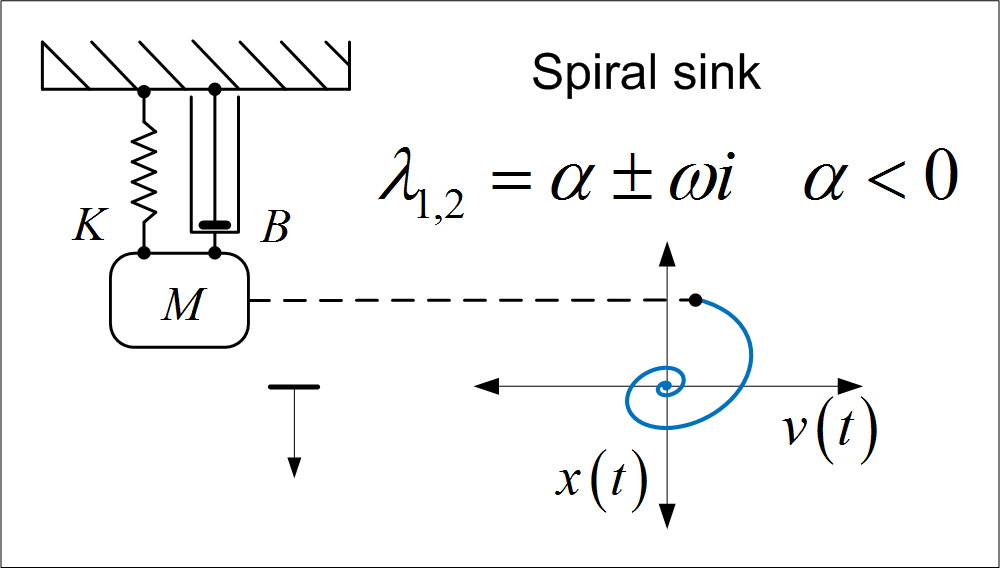  
https://commons.wikimedia.org/wiki/File:Mass_Spring_Damper_System_Phase_plane_Spiral_sink.gif   

---
CORE DEPENDENCIES

numpy: 1.25.2  
matplotlib: 3.7.1

In [1]:
# @title #####__IMPORTS__

locals().clear()
globals().clear()

import time
import numpy as np
import matplotlib.pyplot as plt


# 1) _ALGORITHMS STRUCTURE_


__Monte Carlo:__
1. Generate random samples of damping coefficients:  
\begin{align*}  
c_i \sim U(0, 2 \cdot c_{\text{true}});
\end{align*}
\begin{align*}
\\for \  i = 1, 2, ..., N
\end{align*}
\begin{align*}\end{align*}
2. For each damping coefficient \( c_i \) do:
    a. Simulate the spring-mass-damper system with damping coefficient \( c_i \)
    b. Calculate the error between simulated and true displacement
    c. Store damping coefficient \( c_i \) and corresponding error
3. Return the list of damping coefficients and errors


__Multi-Level Monte Carlo:__
1. Initialize fine levels \( l = 0, 1, ..., L \) and corresponding time steps dt_l
2. For each fine level \( l \) do:  
    a. Set initial damping coefficient estimate c_est = c_true.  
    b. Generate random samples of damping coefficients:
    \begin{align*}
        c_i \sim U(0, 2 \cdot c_{\text{est}});
    \end{align*}
    \begin{align*}     
        \\ if \ l = 0 \
        c_i \sim N(c_{\text{est}}, 2/(1+l) \cdot c_{\text{est}})  
    \end{align*}        
    c. For each damping coefficient \( c_i \) do:  
    >>i. Simulate the spring-mass-damper system with damping coefficient \( c_i \)  
    ii. Calculate the error between simulated and true displacement.
    
    d. Update c_est using the damping coefficient with minimum error
3. Return the list of damping coefficients at each level and total number of compute iterations.

Where U stand for Uniform distribution and N for Normal distribution.



In [2]:
# @title #####__FUNCTION DEFINITION__

#-------------------------------------------------------------------------------

def simulate_spring_mass_damper(mass, spring_constant, damping_coefficient, time_step, total_time):
    num_steps = int(total_time / time_step)
    time = np.linspace(0, total_time, num_steps)
    displacement = np.zeros(num_steps)
    velocity = np.zeros(num_steps)

    # Initial conditions
    displacement[0] = 1.0
    velocity[0] = 0.0

    for i in range(1, num_steps):
        acceleration = (-damping_coefficient * velocity[i-1] - spring_constant * displacement[i-1]) / mass
        velocity[i] = velocity[i-1] + acceleration * time_step
        displacement[i] = displacement[i-1] + velocity[i] * time_step

    return time, displacement

def monte_carlo_simulation(mass, spring_constant, true_damping_coefficient, num_samples):
    print('---------------------------------------------')
    print('MONTE CARLO SIMULATION')
    print()
    np.random.seed(89)
    dt = 0.005
    print(f'Time Step: {dt}')
    damping_coefficients = np.random.uniform(0, 2 * true_damping_coefficient, num_samples) #np.random.normal(loc=true_damping_coefficient, scale=2 * true_damping_coefficient, size=num_samples)
    errors = []
    for damping_coefficient in damping_coefficients:
        time, displacement = simulate_spring_mass_damper(mass, spring_constant, damping_coefficient, time_step=dt, total_time=20.0)
        true_displacement = np.exp(-true_damping_coefficient * time / (2 * mass)) * np.cos(np.sqrt(spring_constant / mass - (true_damping_coefficient / (2 * mass))**2) * time)
        error = np.sum(np.abs(displacement - true_displacement)) / len(time)
        errors.append((damping_coefficient, error))

    return errors

def mlmc_simulation(mass, spring_constant, true_damping_coefficient, num_fine_levels, num_samples):
    print('---------------------------------------------')
    print('MULTI-LEVEL MONTE CARLO SIMULATION')
    print()
    np.random.seed(8989)
    damping_coefficients = []
    compute_iter = 0
    num_iterations = 0

    for l in range(num_fine_levels):
        time_step = 0.08 / 2**(l)
        total_time = 20.0
        num_iterations = num_samples // 5**(l)
        estimated_damping_coefficient = true_damping_coefficient

        print(f'Time Step for Level {l}: {time_step}')
        print(f'Iterations for Level {l}: {num_iterations}')

        level_damping_coefficients = []

        for _ in range(num_iterations):
            if l == 0:
              damping_coefficient = np.random.uniform(0, 2 * estimated_damping_coefficient)
            else:
              damping_coefficient = np.random.normal(loc=estimated_damping_coefficient, scale=2/(1+l) * estimated_damping_coefficient)

            time, displacement = simulate_spring_mass_damper(mass, spring_constant, damping_coefficient, time_step=time_step, total_time=total_time)
            true_displacement = np.exp(-true_damping_coefficient * time / (2 * mass)) * np.cos(np.sqrt(spring_constant / mass - (true_damping_coefficient / (2 * mass))**2) * time)

            error = np.sum(np.abs(displacement - true_displacement)) / len(time)

            # Store the estimated damping coefficient
            level_damping_coefficients.append((damping_coefficient, error))

        # Choose the damping coefficient with minimum error at this level
        estimated_damping_coefficient, _ = min(level_damping_coefficients, key=lambda x: x[1])
        print(f'Estimated Damping Coefficients per Level {l}: {np.round(np.array(estimated_damping_coefficient), 4)}')
        print('------')

        damping_coefficients.append(estimated_damping_coefficient)
        compute_iter += num_iterations
        #print(compute_iter)

    return damping_coefficients, compute_iter


In [3]:
# @title #####__SIMULATION PARAMS__

#-------------------------------------------------------------------------------
# GLOBAL MASS-SPRING PARAMS

mass = 1.0  # Mass of the object (kg)
spring_constant = 1.0  # Spring constant (N/m)
true_damping_coefficient = 0.7  # True damping coefficient (N*s/m)

print("Mass [kg]:", mass)
print("Spring Coefficient [N/m]:", spring_constant)
print("True Damping Coefficient [N*s/m]:", true_damping_coefficient)
print()

#-------------------------------------------------------------------------------
# MONTE CARLO PARAMS

# Parameters
num_samples_mc = 6248  # Number of samples for Monte Carlo simulation

# Perform Monte Carlo simulation
mc_start_t = time.time()
errors = monte_carlo_simulation(mass, spring_constant, true_damping_coefficient, num_samples_mc)
mc_end_t = time.time()

estimated_damping_coefficient_mc, _ = min(errors, key=lambda x: x[1])

print("Estimated Damping Coefficient:", round(estimated_damping_coefficient_mc, 4))
print("Iterations:", num_samples_mc)
print("Time Elapsed [s]:", round((mc_end_t-mc_start_t), 4))
print()

#-------------------------------------------------------------------------------
# MULTI-LEVEL MONTE CARLO PARAMS

# Parameters
num_fine_levels = 5  # Number of fine levels for MLMC
num_samples_mlmc = 5000  # Number of samples for the first level

mlmc_start_t = time.time()
estimated_damping_coefficients_mlmc, iterations = mlmc_simulation(mass, spring_constant, true_damping_coefficient, num_fine_levels, num_samples_mlmc)
mlmc_end_t = time.time()

estimated_damping_coefficient_mlmc = estimated_damping_coefficients_mlmc[-1]

print("Estimated Damping Coefficient:", round(estimated_damping_coefficient_mlmc, 4))
print("Iterations:", iterations)
print("Time Elapsed [s]:", round((mlmc_end_t-mlmc_start_t), 4))
print()


Mass [kg]: 1.0
Spring Coefficient [N/m]: 1.0
True Damping Coefficient [N*s/m]: 0.7

---------------------------------------------
MONTE CARLO SIMULATION

Time Step: 0.005
Estimated Damping Coefficient: 0.6592
Iterations: 6248
Time Elapsed [s]: 49.5322

---------------------------------------------
MULTI-LEVEL MONTE CARLO SIMULATION

Time Step for Level 0: 0.08
Iterations for Level 0: 5000
Estimated Damping Coefficients per Level 0: 0.6577
------
Time Step for Level 1: 0.04
Iterations for Level 1: 1000
Estimated Damping Coefficients per Level 1: 0.6582
------
Time Step for Level 2: 0.02
Iterations for Level 2: 200
Estimated Damping Coefficients per Level 2: 0.6588
------
Time Step for Level 3: 0.01
Iterations for Level 3: 40
Estimated Damping Coefficients per Level 3: 0.6732
------
Time Step for Level 4: 0.005
Iterations for Level 4: 8
Estimated Damping Coefficients per Level 4: 0.668
------
Estimated Damping Coefficient: 0.668
Iterations: 6248
Time Elapsed [s]: 3.3081



# 2) _RESULTS SECTION_

The results shown make it clear how the multi-level method is not only more efficient in terms of time but also more capable of finding a more accurate solution with the same number of iterations performed.

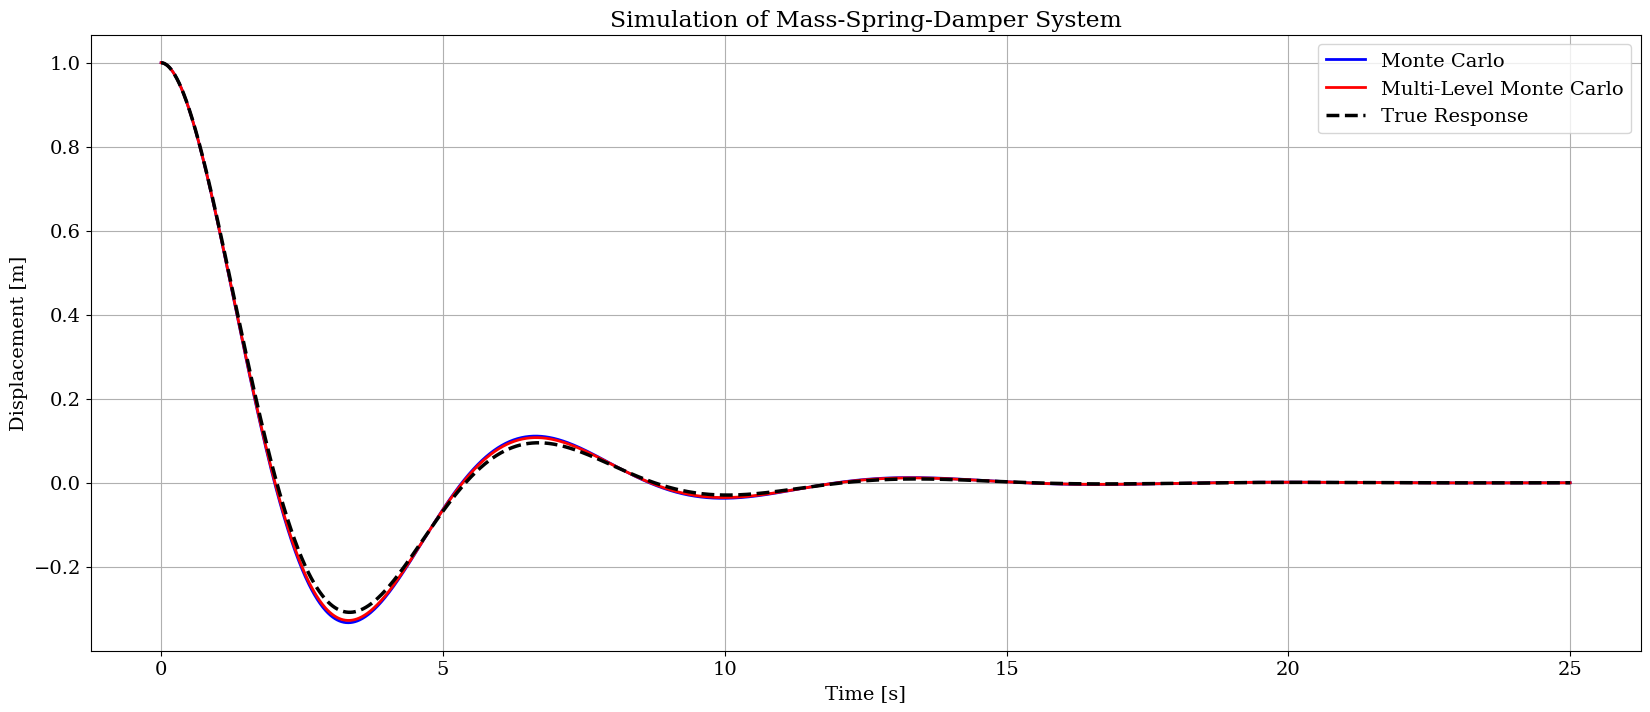

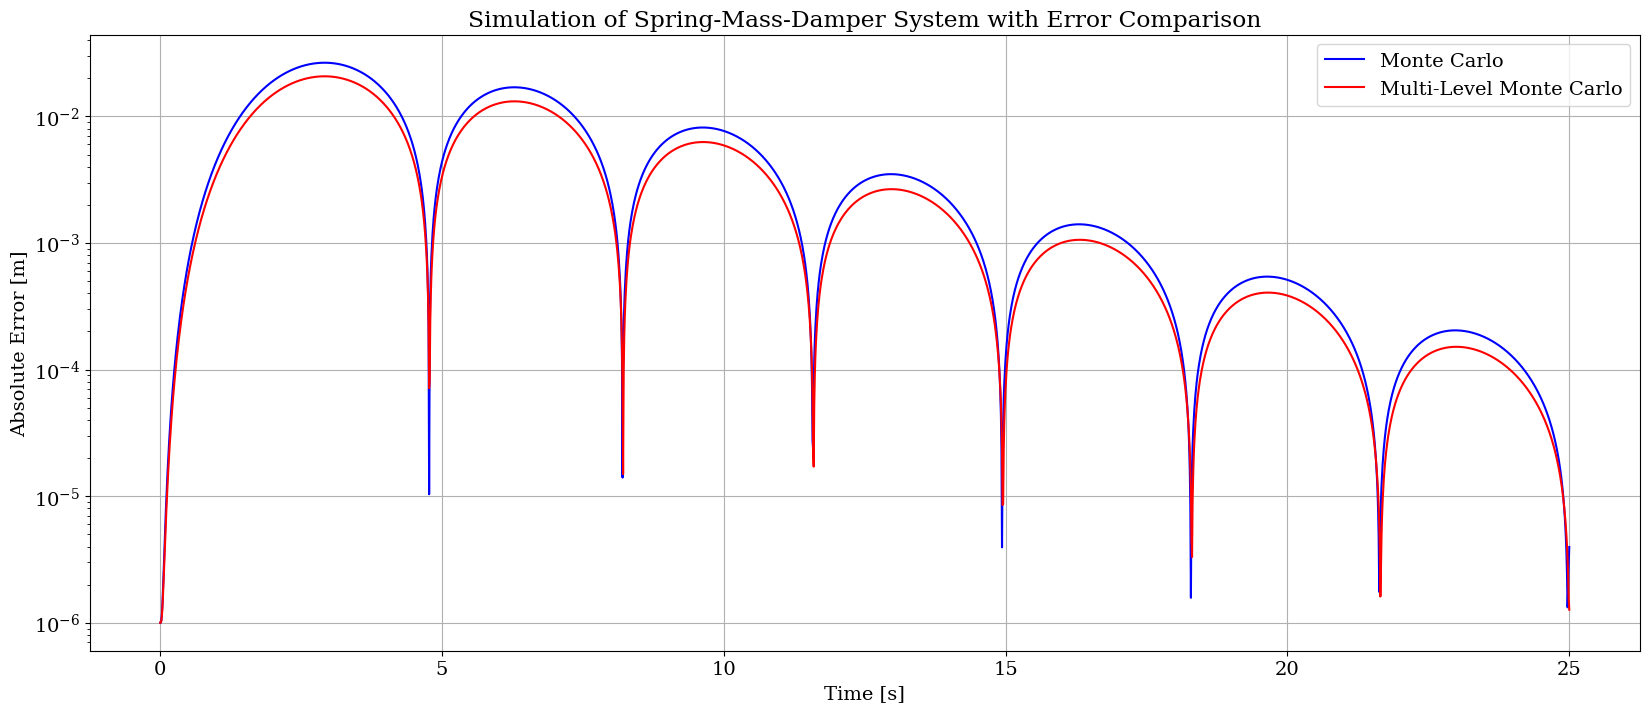

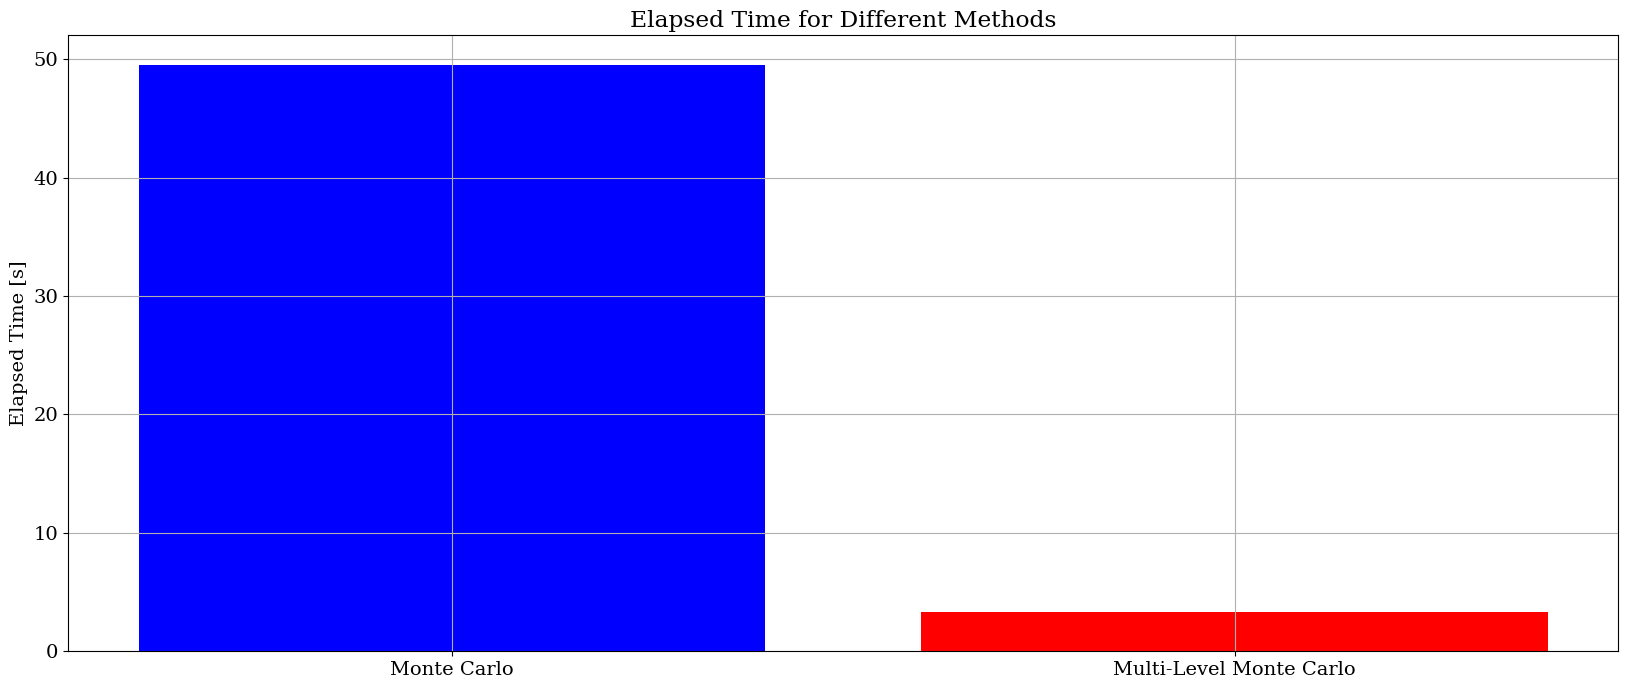

In [4]:
# @title #####__PLOT RESULTS__

time, true_displacement = simulate_spring_mass_damper(mass, spring_constant, true_damping_coefficient, time_step=0.01, total_time=25)
_, displacement_mc = simulate_spring_mass_damper(mass, spring_constant, estimated_damping_coefficient_mc, time_step=0.01, total_time=25)
_, displacement_mlmc = simulate_spring_mass_damper(mass, spring_constant, estimated_damping_coefficient_mlmc, time_step=0.01, total_time=25)

plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(20, 8))
plt.plot(time, displacement_mc, label='Monte Carlo', color='blue', linewidth=2.0)
plt.plot(time, displacement_mlmc, label='Multi-Level Monte Carlo', color='red', linewidth=2.0)
plt.plot(time, true_displacement, label='True Response', color='black', linestyle='dashed', linewidth=2.5)
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.title('Simulation of Mass-Spring-Damper System')
plt.legend()
plt.grid(True)
plt.show()

error_mc = np.abs(true_displacement - displacement_mc) + 1e-6
error_mlmc = np.abs(true_displacement - displacement_mlmc) + 1e-6

plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(20, 8))
plt.semilogy(time, error_mc, label='Monte Carlo', color='blue')
plt.semilogy(time, error_mlmc, label='Multi-Level Monte Carlo', color='red')
plt.xlabel('Time [s]')
plt.ylabel('Absolute Error [m]')
plt.title('Simulation of Spring-Mass-Damper System with Error Comparison')
plt.legend()
plt.grid(True)
plt.show()

times = [(mc_end_t-mc_start_t), (mlmc_end_t-mlmc_start_t)]
methods = ['Monte Carlo', 'Multi-Level Monte Carlo']

plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(20, 8))
plt.bar(methods, times, color=['blue', 'red'])
plt.ylabel('Elapsed Time [s]')
plt.title('Elapsed Time for Different Methods')
plt.grid(True)
plt.show()




---

